In [1]:
import cv2
import numpy as np

from pygo.Webcam import Webcam
from pygo.utils.image import *
from pygo.utils.line import point_in_circle
from skimage import segmentation

from skimage import data, io, segmentation, color
from skimage.future import graph
import numpy as np
from skimage import data, img_as_float
from skimage.filters import sobel, sobel_h, sobel_v, threshold_local

from skimage.segmentation import (morphological_chan_vese,
                                  morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient,
                                  checkerboard_level_set)
from skimage.restoration import inpaint
import ipyplot
from pygo.GoBoard import GoBoard
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,10]
from skimage import (
    data, restoration, util
)


Loading /home/michael/dev/python-lsd/lsd/liblsd.so


In [2]:
ipt = Webcam(default=2)


AttributeError: module 'logging' has no attribute 'debug'

In [2]:
img = ipt.read()
plt.imshow(img)
plt.show()

NameError: name 'ipt' is not defined

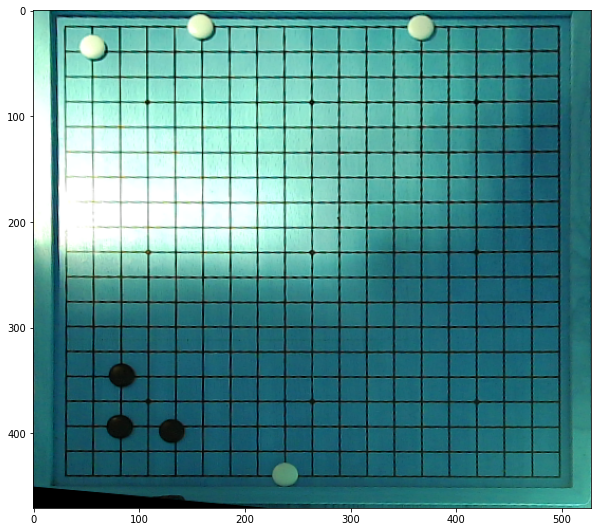

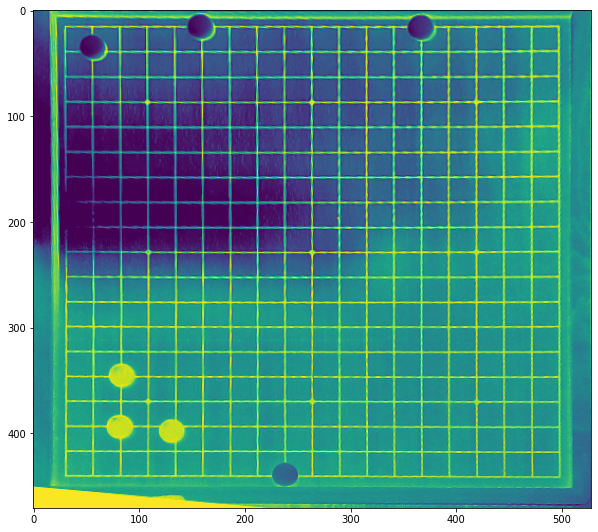

In [26]:
GOB = GoBoard(ipt.getCalibration())
GOB.calib(img)

img_ = GOB.extract(img)
plt.imshow(img_)
plt.show()
clahe = cv2.createCLAHE(clipLimit = 1)
img_ = clahe.apply(toGrayImage(img_))
img_ = toColorImage(img_)
img_c = img.copy()
hsv = toHSVImage(  img_.copy())
yuv = toYUVImage(  img_.copy())
cmyk = toCMYKImage(img_.copy())
gray = toGrayImage(img_.copy())
BRD = GOB.go_board_shifted
plt.imshow(cmyk[:,:,3])
#plt.scatter(BRD[:,0], BRD[:,1])
plt.show()


In [4]:
def get_grid(img, coords):
    board = coords.reshape(19,19,2)
    img = np.zeros_like(img)
    for i in range(19):
        #vertical
        start = tuple(board[0,i].astype(int))
        end   = tuple(board[18,i].astype(int))
        img = cv2.line(img, start, end, color=(255, 255, 255), thickness=5)
        #horizontal
        start = tuple(board[i,0].astype(int))
        end   = tuple(board[i,18].astype(int))
        img = cv2.line(img, start, end, color=(255, 255, 255), thickness=5)
    return img


In [5]:
# Remove horizontal
def remove_vertical(image, thresh):
    # Remove horizontal
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,25))
    detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
    cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        cv2.drawContours(image, [c], -1, 255, 1 )

    # Repair image
    repair_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (6,1))
    result = 255 - cv2.morphologyEx(255 - image, cv2.MORPH_CLOSE, repair_kernel, iterations=1)
    return result


In [6]:
# Remove horizontal
def remove_horizontal(image, thresh):
    # Remove horizontal
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25,1))
    detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
    cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        cv2.drawContours(image, [c], -1, 255, 1)

    # Repair image
    repair_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,6))
    result = 255 - cv2.morphologyEx(255 - image, cv2.MORPH_CLOSE, repair_kernel, iterations=1)
    return result



In [7]:
def extract_v(mask):
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,17))
    mask_h = cv2.morphologyEx(mask, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
    return mask_h

In [8]:
def extract_h(mask):
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17,1))
    mask_h = cv2.morphologyEx(mask, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
    return mask_h

In [9]:
def create_mask(img):
    blur = cv2.GaussianBlur(img, (5,5),1)
    
    t = threshold_local(blur, 25)
    mask = blur > t
    mask = toByteImage(mask)
    mask_v_p = extract_v(mask)
    mask_h_p = extract_h(mask)
    mask_p = cv2.add(mask_v_p, mask_h_p)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    mask_p = cv2.dilate(mask_p, kernel)
    '''
    t = threshold_local(255-blur, 25)
    mask = blur > t
    mask = toByteImage(mask)
    mask_v_n = extract_v(mask)
    mask_h_n = extract_h(mask)
    mask_n = cv2.add(mask_v_n, mask_h_n)
    '''
    return mask_p

In [13]:
def mask_lines(img):
    mask = create_mask(img)
    
    plt.imshow(mask)
    plt.show()
    mask = mask // 255
    inpainted = inpaint.inpaint_biharmonic(img, mask)
    plt.imshow(inpainted)
    plt.show()
    
    img = remove_horizontal(img.copy(), mask)
    img = remove_vertical(img.copy(),mask)
    plt.imshow(img)
    plt.show()
    '''
    dx = np.abs(toByteImage(sobel_h(img)))
    dy = np.abs(toByteImage(sobel_v(img)))
    mask = cv2.add(dx,dy)
    thresh = threshold_local(dx, 25)
    dx = dx > thresh
    plt.imshow(dx)
    plt.show()
    '''
    mask = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
    '''
    kernel_x = cv2.getStructuringElement(cv2.MORPH_RECT, (3,1))
    kernel_y = cv2.getStructuringElement(cv2.MORPH_RECT, (3,1))
    mask = cv2.dilate(mask, kernel_y)
    mask = cv2.dilate(mask, kernel_x)
    '''
    plt.imshow(mask)
    plt.show()
    img = cv2.inpaint(img, mask, 3, cv2.INPAINT_NS)
    return img

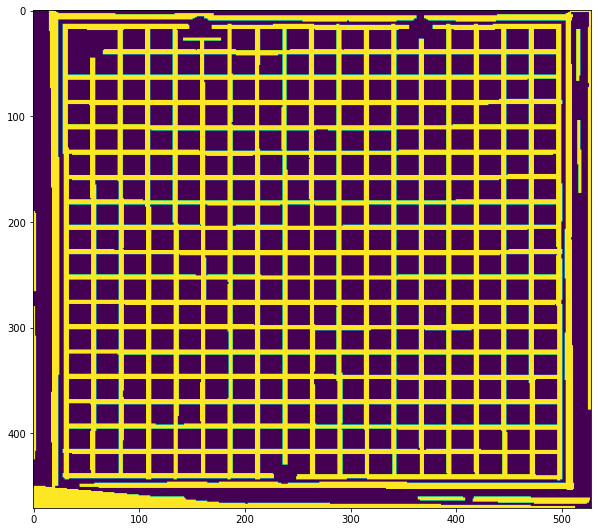

In [ ]:
cmyk3 = mask_lines(cmyk[:,:,3])
plt.imshow(cmyk3)
plt.show()

In [31]:
img_.shape

(471, 528, 3)

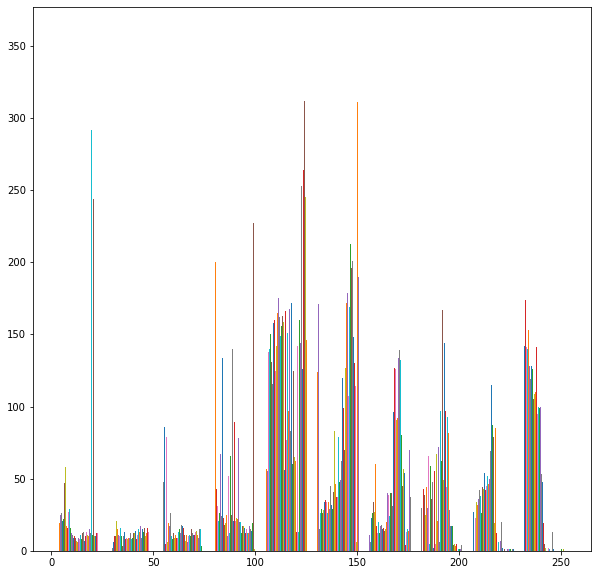

In [32]:
plt.hist(toGrayImage(img_))
plt.show()

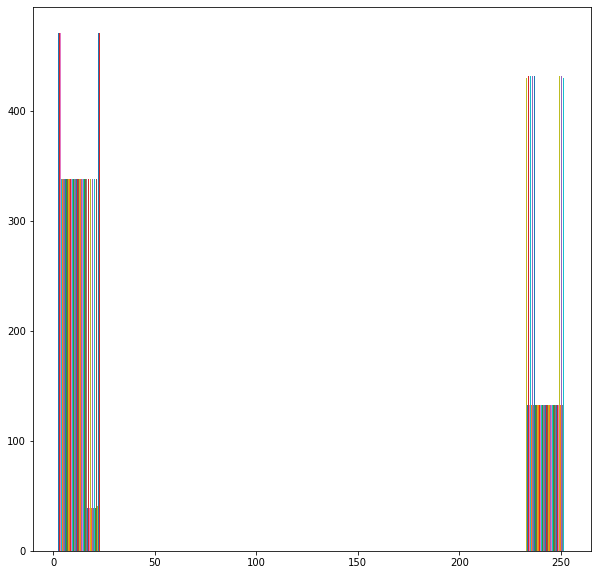

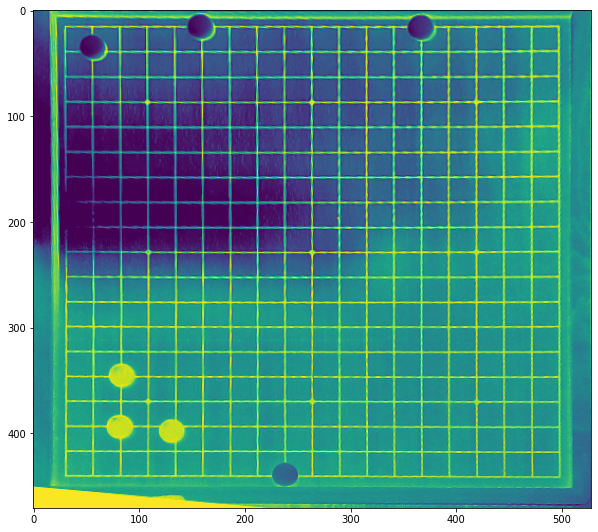

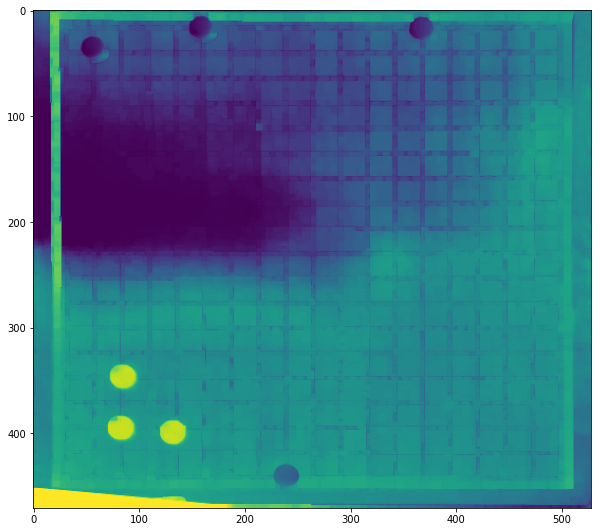

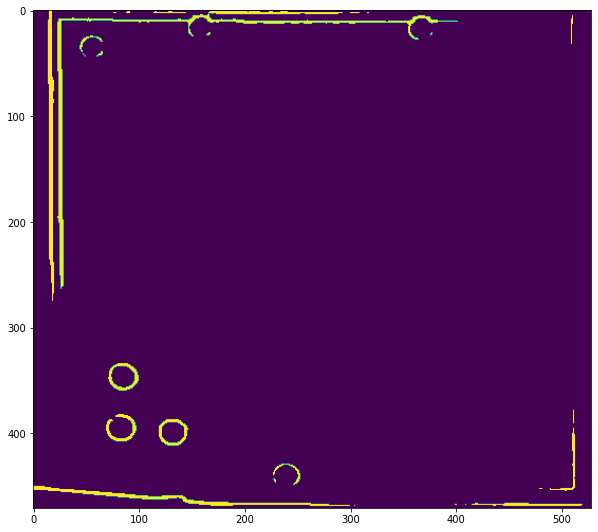

In [28]:
img_grid = toGrayImage(get_grid(img_, BRD))

grid = sobel(cmyk[:,:,3])
grid = toByteImage(grid)
cmyk3 = toByteImage(cmyk[:,:,3])
grid = cv2.threshold(grid, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
plt.imshow(cmyk3)
plt.show()
cmyk3 = remove_horizontal(cmyk3.copy(), grid)
cmyk3 = remove_vertical(cmyk3.copy(), grid)
plt.imshow(cmyk3)
plt.show()
cmyk3 = cv2.GaussianBlur(cmyk3,(5,5),0)
grid = sobel(cmyk3)
grid = toByteImage(grid)
out = cv2.threshold(grid, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]

plt.imshow(out)
plt.show()
                       
                    

In [14]:
def remove_circles_not_on_grid(circles, grid):
    circles_out = []
    for crl in circles:
        if np.any(point_in_circle(grid, np.array(crl))):
            circles_out.append(crl)
    return circles_out
        

10
13
hough


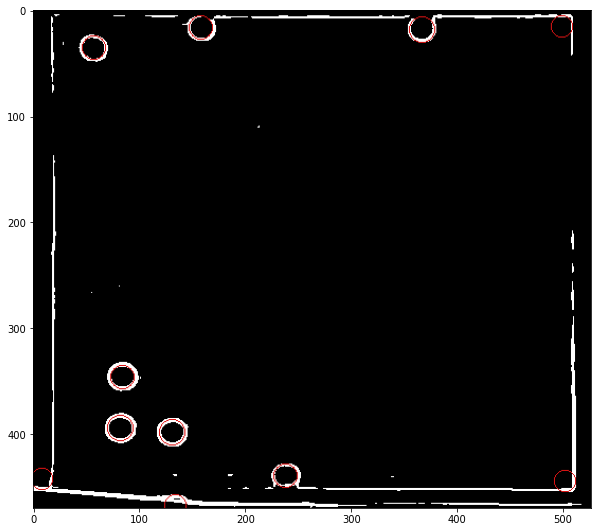

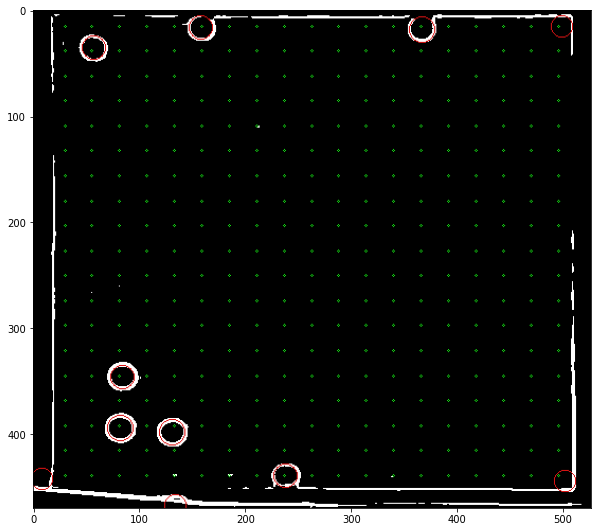

In [15]:
cell_w = (np.mean(np.diff(GOB.go_board_shifted.reshape(19,19,2)[:,:,0], axis=0))//2).astype(int)
cell_h = (np.mean(np.diff(GOB.go_board_shifted.reshape(19,19,2)[:,:,1], axis=1))//2).astype(int)

minRadius = min(cell_w, cell_h) -1
maxRadius = max(cell_w, cell_h) +1
print(minRadius)
print(maxRadius)

from skimage.draw import circle_perimeter

from skimage.transform import hough_circle, hough_circle_peaks
hough_radii = np.arange(minRadius, maxRadius, 1)
hough_res = hough_circle(out, hough_radii)
print('hough')
# Select the most prominent 3 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, 
                                           min_xdistance=2*minRadius,
                                           min_ydistance=2*minRadius)

from skimage import data, color
# Draw them
image = color.gray2rgb(out.copy())
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius,
                                    shape=img_.shape)
    image[circy, circx] = (220, 20, 20)

plt.imshow(image, cmap=plt.cm.gray)
plt.show()
circles = zip(cx,cy,radii)

circles_clean = remove_circles_not_on_grid(circles, GOB.go_board_shifted)

for center_x, center_y, radius in circles_clean:
    circy, circx = circle_perimeter(center_y, center_x, radius,
                                    shape=img_.shape)
    image[circy, circx] = (220, 20, 20)
    
for x,y in BRD.astype(int):
    circy, circx = circle_perimeter(y, x, 1,
                                    shape=img_.shape)
    image[circy, circx] = (20, 220, 20)

plt.imshow(image, cmap=plt.cm.gray)
plt.show()

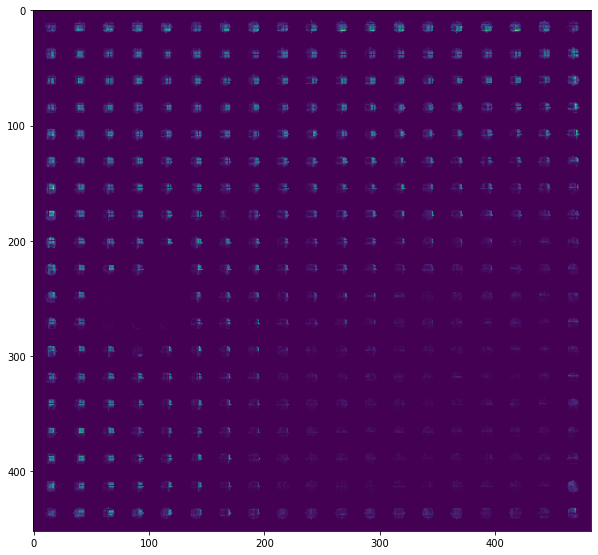

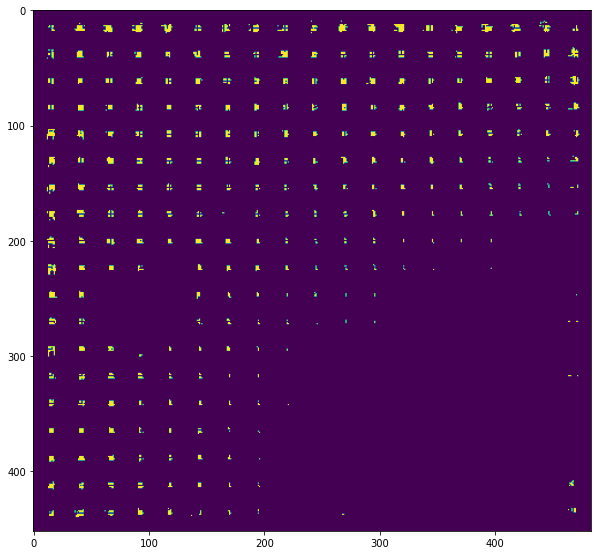

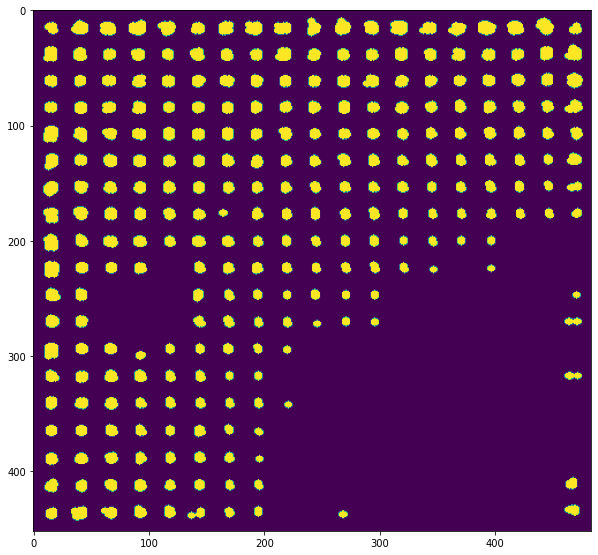

In [15]:
map = sobel(cmyk[:,:,3])
map = toByteImage(map)
cell_w = (np.mean(np.diff(GOB.go_board_shifted.reshape(19,19,2)[:,:,0], axis=0))//2).astype(int)
cell_h = (np.mean(np.diff(GOB.go_board_shifted.reshape(19,19,2)[:,:,1], axis=1))//2).astype(int)
        
cross = cv2.getStructuringElement(cv2.MORPH_CROSS, (cell_w, cell_w))

if cell_w % 2 == 0:
    cell_w -= 1
corner = np.zeros((cell_w, cell_w))
corner[cell_w//2,:cell_w//2] = 255
corner[:cell_w//2,cell_w//2] = 255
corner[cell_w//2,cell_w//2] = 255

side = np.zeros((cell_w, cell_w))
side[:,cell_w//2] = 255
side[cell_w//2,:cell_w//2] = 255
corner = corner.astype(np.uint8)
side = side.astype(np.uint8)


ellipse = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
map_center = cv2.morphologyEx(map, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (3,3)))

map_corner = np.zeros_like(map).astype(float)
map_side = []
factor = np.zeros_like(map).astype(np.int32)
coord = GOB.go_board_shifted.astype(int).reshape(19,19,-1)

for x in range(19):
    for y in range(19):
        crd = coord[x,y]
        if x in [0,18] or y in [0,18]:
            cv2.circle(factor, crd, 5, 2, -1)        
        elif np.isin([x,y], [[0,0], [0,18], [18,0], [18,18]]).any():            
            cv2.circle(factor, crd, 5, 4, -1)        
        else:        
            cv2.circle(factor, crd, 5, 1, -1)
        
for _ in range(4):    
    flt = cv2.morphologyEx(map, cv2.MORPH_ERODE, corner).astype(float)
    flt = (flt - flt.min()) / (flt.max() - flt.min())
    map_corner += flt
    #map_side.append(cv2.morphologyEx(map, cv2.MORPH_ERODE, side))
    corner = np.rot90(corner)
    #side = np.rot90(side)
    
map_corner = factor * map_corner
map_corner = (map_corner - map_corner.min()) / (map_corner.max() - map_corner.min()) * 255
grid = toByteImage(map_corner)

#grid = cv2.morphologyEx(map_center, cv2.MORPH_ERODE, cross)
#grid = toByteImage(grid)

plt.imshow(grid)
plt.show()
_, grid = cv2.threshold(grid, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(grid)
plt.show()
grid = cv2.dilate(grid, ellipse, iterations=1)

# initial markers
markers = np.ones_like(map).astype(np.int32)
mask = np.ones_like(map)
plt.imshow(grid)
plt.show()





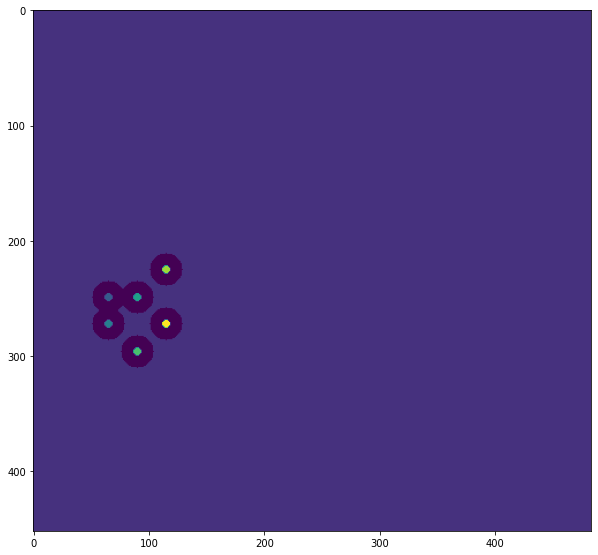

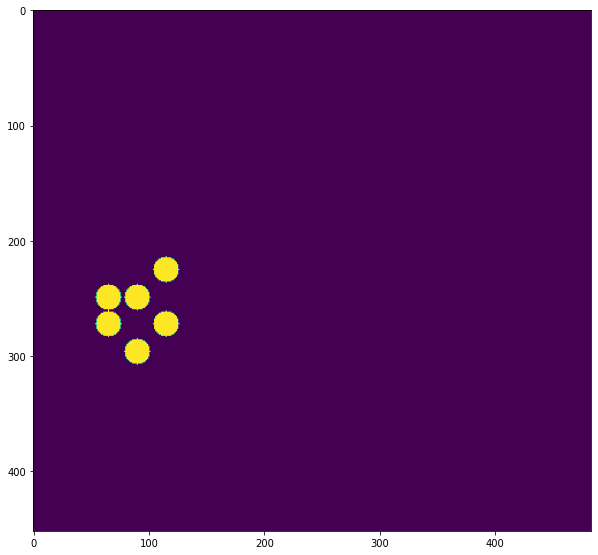

In [16]:
id = 2
for coord in GOB.go_board_shifted.reshape(-1,2).astype(int):
    if grid[coord[1], coord[0]] == 0 and\
        np.any(point_in_circle(coord, np.array(circles_clean))):

        cv2.circle(markers, coord, cell_w+3, 0, -1)
        cv2.circle(markers, coord, 2, id, 2)

        cv2.circle(mask, coord, cell_w, 255, -1)
        id += 1
import matplotlib.pyplot as plt
plt.imshow(markers)
plt.show()
plt.imshow(mask)
plt.show()

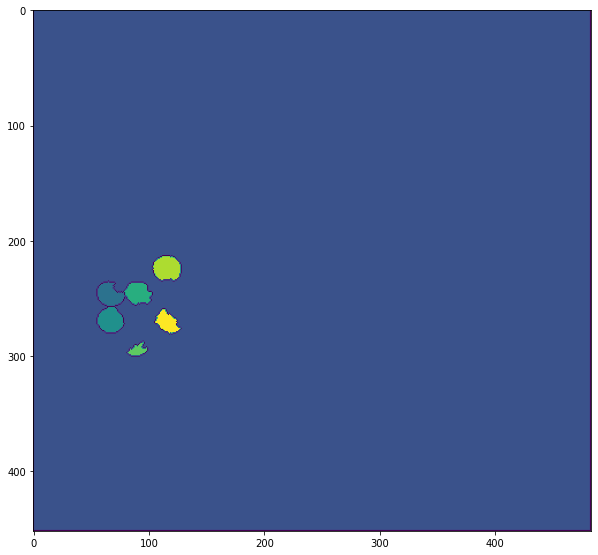

In [17]:
map = toGrayImage(map)
map = toByteImage(map)
map = toColorImage(map)
water = cv2.watershed(img_, markers)
#toColorImage(cmyk[:,:,3]), markers)
plt.imshow(water)
plt.show()

In [7]:
import cv2
import numpy as np

%matplotlib inline

from pygo.Webcam import Webcam
from pygo.utils.image import *
from pygo.utils.line import point_in_circle
from skimage import segmentation

from skimage import data, io, segmentation, color
from skimage.future import graph
import numpy as np
from skimage import data, img_as_float
from skimage.filters import sobel, sobel_h, sobel_v, threshold_local

from skimage.segmentation import (morphological_chan_vese,
                                  morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient,
                                  checkerboard_level_set)
from skimage.restoration import inpaint
import ipyplot
from pygo.GoBoard import GoBoard
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,10]
from skimage import (
    data, restoration, util
)
from IPython.display import display 
import ipywidgets as widgets 
from ipywidgets import interact, Layout, fixed
import warnings

interactive(children=(IntSlider(value=31, description='kernel', max=61, min=1, step=2), IntSlider(value=2, des…

<function __main__.f(img, kernel, c)>

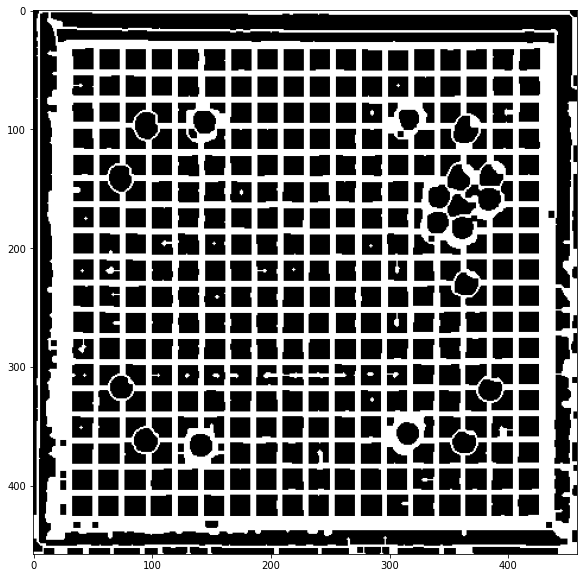

In [40]:



img = cv2.imread('out.png', cv2.IMREAD_GRAYSCALE)
def f(img, kernel, c):
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, kernel, c)
    img = toByteImage(sobel(img))
    _,img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (3,3)), iterations=2)
    #img = cv2.dilate(img, (3,3),iterations=1)
    #img = cv2.dilate(img, (5,5),iterations=2)
    ax_neu.imshow(img, cmap='gray')
    fig.canvas.draw()
    display(fig)

fig = plt.figure(figsize=(10,10))
ax_neu = fig.add_subplot(111) 
ax_neu.imshow(img, cmap="gray")
interact(f, 
         img=fixed(img),
         kernel=widgets.IntSlider(min=1,max=61,step=2,value=31), 
         c=widgets.IntSlider(min=-5,max=5,step=1,value=2))

interactive(children=(IntSlider(value=3, description='kernel', max=21, min=1, step=2), IntSlider(value=0, desc…

<function __main__.f(kernel, c)>